# SQNR Bound

Simulated and theoretical signal-to-quantization-noise ratio as a function of self-interference

## Setup

In [1]:
from IPython.display import display, Markdown

import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# For link-level simulations
from sionna.channel import AWGN, ApplyOFDMChannel, time_to_ofdm_channel
from sionna.ofdm import OFDMModulator, ResourceGrid, ResourceGridMapper
from sionna.nr import CarrierConfig
from sionna.rt import Antenna
from sionna.utils import QAMSource
from sionna.signal import fft

from pathlib import Path
from cissir.adc import max_abs_complex, papr, quantize_signal, snr_thermal, sqnr_bound
from cissir.beamforming import plot_beamforming_polar, Beamspace, sionna_mimo_axes

import pandas as pd
import seaborn as sns

from cissir import physics as phy, params, optimization as opt, visualization as viz
viz.paper_style()

import itertools
from tqdm.notebook import tqdm

base_path = Path.cwd().parent
plot_path = base_path/"plots"
res_path = base_path/"results"

In [2]:
# Global parameters

c = params.c
fc = params.fc_hz
wavelength_m = params.wavelength_m

ula_el_spacing = params.array_electrical_spacing

N_r = params.n_rx
N_t = params.n_tx

# Number of beams
L_r = params.num_beams
L_t = params.num_beams

Q_bits = 6 # Each complex component (I and Q) is quantized with Q bits

In [3]:
## Waveform params

c_config = CarrierConfig(subcarrier_spacing=params.subcarrier_spacing_khz,
                         cyclic_prefix="normal")
num_subcarriers = params.num_prb * params.subcarriers_per_rb
subcarrier_spacing = params.subcarrier_spacing_khz * 1e3

Ts_sec = c_config.t_c
fft_size = round(1e-3/(c_config.subcarrier_spacing * Ts_sec))
cyclic_prefix_length = round(c_config.cyclic_prefix_length/Ts_sec)
digital_bw_hz = 1/Ts_sec

sig_bw_hz = num_subcarriers * subcarrier_spacing
sig_bw_frac = num_subcarriers/fft_size

t_channel_s = tf.range(cyclic_prefix_length, dtype=tf.float64) * Ts_sec
distance_m = phy.delay2distance(t_channel_s)

## OFDM configuration
num_ofdm_symbols = 1 # Number of OFDM symbols forming the resource grid
dc_null = True # Null the DC subcarrier
pilot_pattern = None # Pilot pattern
pilot_ofdm_symbol_indices = None # Index of OFDM symbols carrying pilots

null_carriers = fft_size - num_subcarriers
num_guard_carriers = [null_carriers//2, null_carriers//2] # Number of guard carriers on each side

rg = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                 fft_size = fft_size,
                 subcarrier_spacing = subcarrier_spacing,
                 num_tx = 1,
                 num_streams_per_tx = 1,
                 cyclic_prefix_length = cyclic_prefix_length,
                 dc_null = dc_null,
                 pilot_pattern = pilot_pattern,
                 pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                 num_guard_carriers = num_guard_carriers)

### Beam codebook


In [4]:
with np.load(res_path/"sdp_ph_full_codebooks.npz") as cb_data:
    opt_att = cb_data["att_opt"]
    tgt_att = cb_data["att_tgt"]
    att_points = len(opt_att)
    #print(f"Loading codebooks for {opt_att} dB SI attenuation")
    opt_tx_codebooks = cb_data["tx"]
    assert opt_tx_codebooks.shape == (att_points, N_t, L_t), "Unexpected shape for Tx codebook"
    opt_rx_codebooks = cb_data["rx"]
    assert opt_rx_codebooks.shape == (att_points, N_r, L_r), "Unexpected shape for Tx codebook"

    tx_degs = cb_data["tx_degrees"]
    rx_degs = cb_data["rx_degrees"]
    beam_degs = tx_degs
    
    tx_codebook_p = opt_tx_codebooks[0,]
    rx_codebook_p = opt_rx_codebooks[0,]

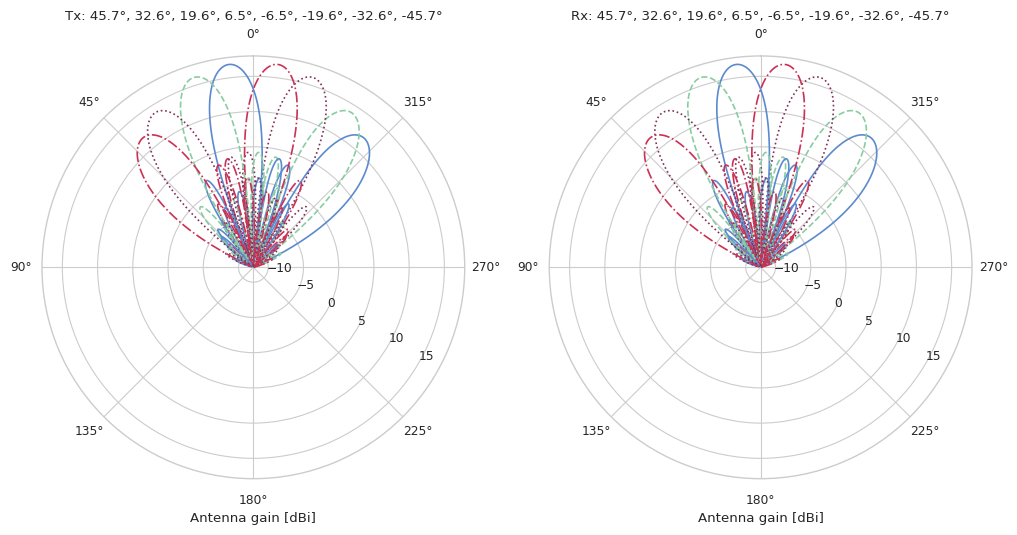

In [6]:
antenna_pattern = Antenna(params.antenna_pattern, polarization=params.antenna_polarization).patterns
rad_pattern = lambda x: sum(sum(np.abs(p)**2 for p in pat(np.pi/2, x)) for pat in antenna_pattern)

f, (ax_tx, ax_rx) = plt.subplots(1, 2, figsize=(12,6), subplot_kw={'projection': 'polar'}) 
_ = plot_beamforming_polar(tx_codebook_p, transmit=True, element_pattern=rad_pattern, axis=ax_tx)
_ = plot_beamforming_polar(rx_codebook_p, transmit=False, element_pattern=rad_pattern, axis=ax_rx)

_ = ax_tx.set_title(f"Tx: "+", ".join(f"{bd:.1f}°" for bd in tx_degs[::-1]))
_ = ax_rx.set_title(f"Rx: "+", ".join(f"{bd:.1f}°" for bd in rx_degs[::-1]))


In [7]:
tx_cb_matrix = tf.cast(tx_codebook_p, dtype=tf.complex64)  # (N_t, L_t)
rx_cb_matrix = tf.cast(rx_codebook_p, dtype=tf.complex64)  # (N_r, L_r)

Beamforming method

### Backscatter channels 

In [8]:
si_num_taps = 2

with np.load(res_path/"channel_impulse_responses.npz") as rt_data:
    t_rt = tf.constant(rt_data['t_channel_s'])
    assert tf.math.reduce_all(tf.equal(t_rt, t_channel_s)), "Wrong assumed time scale from simulations"

    ht_tgt = tf.constant(rt_data['ht_tgt'], dtype=tf.complex64)
    ht_si_full = tf.constant(rt_data['ht_si'], dtype=tf.complex64)

    ht_si = tf.reduce_sum(ht_si_full[:si_num_taps,], axis=0, keepdims=True)


h_mimo = tf.concat([ht_si, ht_tgt], axis=0)
h_mimo.shape

TensorShape([2, 1, 8, 1, 8, 1, 2176])

-68.5 db SI:	-79.5 to -68.5 dB achieved. (11.0 dB)
-77.5 db SI:	-80.9 to -77.5 dB achieved. (3.4 dB)
-87.5 db SI:	-92.8 to -87.6 dB achieved. (5.2 dB)
-101.5 db SI:	-106.0 to -101.8 dB achieved. (4.2 dB)


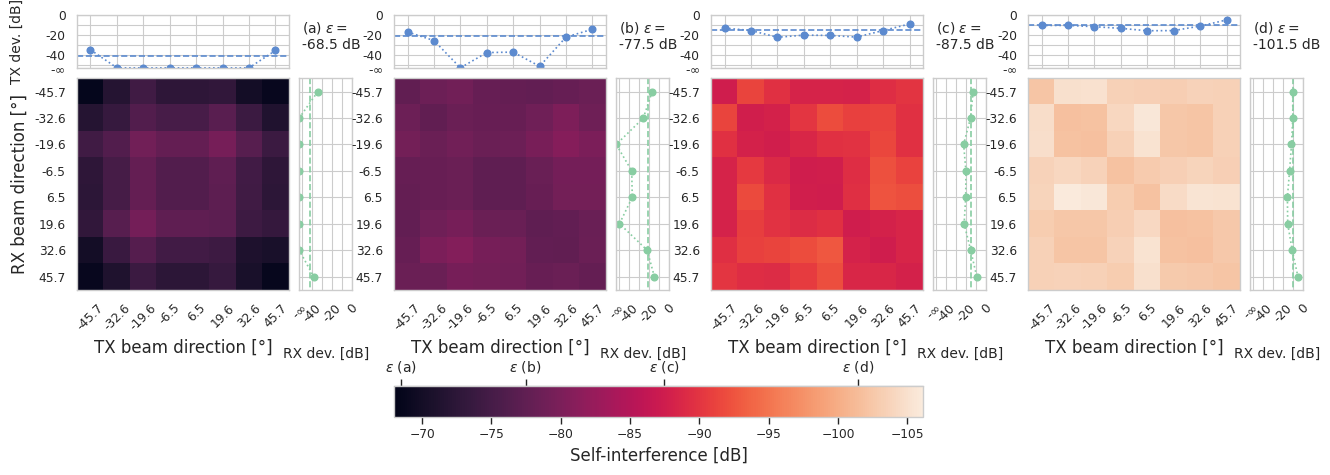

In [9]:
si_vmin, si_vmax = -106.1, -68
dev_min, dev_max = -43, -0
inf_val = -53
dev_ticks = [inf_val, -50, -40, -30, -20, -10, 0]
dev_tlabel = ["-$\infty$", "", "-40", "", "-20", "", "0"]
h_si_beam = np.squeeze(ht_si).transpose(2, 0, 1)

tx_ref = opt_tx_codebooks[0,]
rx_ref = opt_rx_codebooks[0,]

#fig, axes = plt.subplots(1, 4, figsize=(40,6))
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(2, 4, height_ratios=[1, 0.1], hspace=0.3, wspace=0.5)

att_indices = (3, att_points//4+2, att_points//2+1, 3 * att_points//4+4)

subfigs = ["("+c+")" for c in "abcd"]

si_vals = []

tx_color = viz.palette[0]
rx_color = viz.palette[1]

si_ticks = []
im = None

for i, att_i in enumerate(att_indices):
    ax = fig.add_subplot(gs[0, i])
    tgt_si = -tgt_att[att_i]
    si_vals.append(tgt_si)
    si_ticks.append(r"$\varepsilon$ " + subfigs[i])

    tx_cb = opt_tx_codebooks[att_i,]
    rx_cb = opt_rx_codebooks[att_i,]
    cb_si = opt.codebook_si(tx_cb, rx_cb, h_si_beam)
    tx_error =np.maximum(phy.db2power(inf_val), [opt.codebook_deviation_power(tx_cb[:, i:i + 1], tx_ref[:, i:i + 1]) for i in range(L_t)])
    rx_error =np.maximum(phy.db2power(inf_val), [opt.codebook_deviation_power(rx_cb[:, i:i + 1], rx_ref[:, i:i + 1]) for i in range(L_r)])

    tx_cb_err = opt.codebook_deviation_power(tx_cb, tx_ref)
    rx_cb_err = opt.codebook_deviation_power(rx_cb, rx_ref)

    si_cb_db = phy.mag2db(cb_si)
    si_min, si_max = si_cb_db.min(), si_cb_db.max()

    print(f"{tgt_si:.1f} db SI:\t{si_min:.1f} to {si_max:.1f} dB achieved. ({si_max-si_min:.1f} dB)")
    
    im = ax.imshow(si_cb_db, vmin=si_vmin, vmax=si_vmax,
               cmap="rocket_r")
    plt.grid()

    ax.set_xticks(range(len(tx_degs)), [f"{d:.1f}" for d in tx_degs])
    ax.tick_params(axis='x', labelrotation=45)

    ax.set_yticks(range(len(rx_degs)), [f"{d:.1f}" for d in rx_degs])
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
    ax_histx.tick_params(bottom=False, labelbottom=False)
    ax_histx.plot(phy.pow2db(tx_error), ":o", color=tx_color)
    ax_histx.plot([-.5, L_t-.5], [phy.pow2db(tx_cb_err)] * 2, "--", color=tx_color)
    ax_histx.set_ylim(dev_min, dev_max)
    ax_histx.set_yticks(dev_ticks, dev_tlabel)
    if i== 0:
        ax_histx.set_ylabel("TX dev. [dB]\n", size=10)
    ax_histx.grid(visible=True, which="both")
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
    ax_histy.tick_params(left=False, labelleft=False)
    ax_histy.plot(phy.pow2db(rx_error), range(L_r), ":o", color=rx_color)
    ax_histy.plot([phy.pow2db(rx_cb_err)] * 2, [-.5, L_r - .5], "--", color=rx_color)
    
    ax_histy.set_xlim(dev_min, dev_max)
    ax_histy.set_xticks(dev_ticks, dev_tlabel)
    ax_histy.tick_params(axis='x', labelrotation=45)
    ax_histy.set_xlabel("\nRX dev. [dB]", size=10)
    ax_histy.grid(visible=True, which="both")
    
    ax.text(8, -1.0, f"{subfigs[i]} "+ r"$\varepsilon=$" +f"\n{tgt_si:.1f} dB\n", size=10)
    ax.set_xlabel("TX beam direction [°]", size=12)
    if i == 0:
        ax.set_ylabel("RX beam direction [°]", size=12)
cax = fig.add_subplot(gs[-1, 1:-1])
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label("Self-interference [dB]", size=12)
cbar.ax.invert_xaxis()
ax_sec = cbar.ax.secondary_xaxis('top')
_ = ax_sec.set_xticks(si_vals, si_ticks, size=10)
plt.savefig(plot_path/"si_heatmaps.pdf", bbox_inches="tight")

In [10]:
# Beam forming
rx_axis, tx_axis = sionna_mimo_axes("ofdm")
opt_beamspace = Beamspace(receive_axis=rx_axis, transmit_axis=tx_axis)
h_siso = opt_beamspace([h_mimo, rx_cb_matrix, tx_cb_matrix])
h_beams = tf.squeeze(h_siso, axis=(1, 3, 5))
h_beams = tf.transpose(h_beams, perm=[0, 3, 1, 2])
h_beams = tf.linalg.diag_part(h_beams)

In [11]:
l_max = tf.argmax(tf.reduce_max(tf.abs(h_beams[-1,]), axis=0))
t_argmax = tf.argmax(tf.reduce_max(tf.abs(h_beams[-1,]), axis=1))
dist_max = distance_m[t_argmax] + 12

In [12]:
hf_list = []
opt_tx_beam = opt_tx_codebooks[..., l_max:l_max+1]
opt_rx_beam = opt_rx_codebooks[..., l_max:l_max+1]
for i in range(att_points):
    tx_cb_vec = tf.cast(opt_tx_beam[i,], dtype=tf.complex64)
    rx_cb_vec = tf.cast(opt_rx_beam[i,], dtype=tf.complex64)
    h_siso = opt_beamspace([h_mimo, rx_cb_vec, tx_cb_vec])
    h_b = tf.squeeze(h_siso, axis=(1, 3, 5))
    h_b = tf.transpose(h_b, perm=[0, 3, 1, 2])
    h_b = tf.linalg.diag_part(h_b)
    ht_ = h_b[..., 0]

    hfreq = time_to_ofdm_channel(tf.reshape(ht_, shape=(1, ht_.shape[0], 1, 1, 1, 1, ht_.shape[-1])) * 
                             tf.ones(shape=(1, 1, 1, 1, 1, fft_size+cyclic_prefix_length, ht_.shape[-1]),
                                     dtype=ht_.dtype), rg, l_min=0)
    hf_list.append(hfreq)

In [13]:
hfreq_opt = tf.stack(hf_list, axis=0)

In [14]:
ht_si.shape

TensorShape([1, 1, 8, 1, 8, 1, 2176])

In [15]:
si_beam = []
tx_dev = []
h_si_beam = np.squeeze(ht_si).transpose(2, 0, 1)
tx_ref = opt_tx_beam[0]
for i in range(att_points):
    si_b = opt.codebook_si(opt_tx_beam[i], opt_rx_beam[i,], h_si_beam)
    si_beam.append(phy.mag2db(np.max(si_b)))
    tx_d = opt.codebook_deviation_power(opt_tx_beam[i], tx_ref)
    tx_dev.append(phy.pow2db(max(tx_d, 1e-10)))

In [16]:
beam_df = pd.DataFrame({"tx_dev_db": tx_dev, "si_db": si_beam})
beam_df

,tx_dev_db,si_db
0,-100.000000,-79.123000
1,-99.117299,-79.122095
2,-96.096378,-79.121905
3,-100.000000,-79.122631
4,-100.000000,-79.122478
5,-99.410478,-79.122261
6,-96.458590,-79.121963
7,-100.000000,-79.122643
8,-100.000000,-79.122610
9,-100.000000,-79.123000


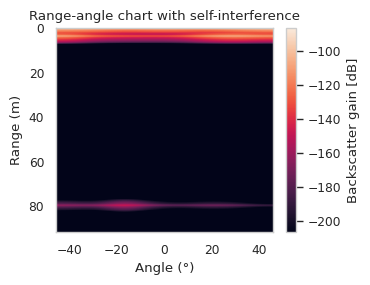

In [17]:
dr_db = 120
h_beams_db = phy.mag2db(tf.abs(np.sum(h_beams, axis=0)) + 1e-20)
vmax = np.max(h_beams_db)
vmin = vmax - dr_db

extent = (min(beam_degs), max(beam_degs), min(distance_m), max(distance_m))
plt.imshow(h_beams_db, vmin=vmin, vmax=vmax, interpolation='bicubic',
           origin='lower', extent=extent, aspect="auto"),
plt.xlabel("Angle (°)")
plt.ylabel("Range (m)")
plt.xlim(extent[1], extent[0])
plt.ylim(0, dist_max)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
cbar = plt.colorbar()
cbar.set_label("Backscatter gain [dB]")
plt.grid(visible=False)
_ = plt.title("Range-angle chart with self-interference")
plt.savefig(plot_path/"range_angle.svg", bbox_inches="tight")

In [18]:
ht = h_beams[..., l_max]
hfreq = time_to_ofdm_channel(tf.reshape(ht, shape=(1, ht.shape[0], 1, 1, 1, 1, ht.shape[-1])) * 
                             tf.ones(shape=(1, 1, 1, 1, 1, fft_size+cyclic_prefix_length, ht.shape[-1]),
                                     dtype=ht.dtype), rg, l_min=0)

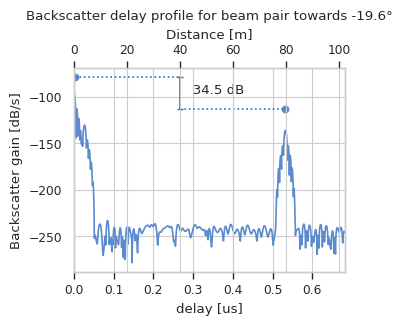

In [19]:
t_vec = t_channel_s * 1e6

hr1 = tf.abs(tf.norm(ht[-1,], ord=1))
hr2 = tf.abs(tf.norm(ht[-1,], ord=2))
hs1_init = tf.abs(tf.norm(ht[0,], ord=1))

t_complex = tf.cast(t_vec, dtype=ht.dtype)
tmean_si = tf.cast(tf.norm(t_complex * ht[0,], ord=1)/hs1_init, dtype=t_vec.dtype)
tmean_r = tf.cast(tf.norm(t_complex * ht[-1,], ord=1)/hr1, dtype=t_vec.dtype)

srar_init = phy.mag2db(hs1_init / hr1)

ht_db = phy.mag2db(np.abs(np.sum(ht, axis=0)))

plt.plot(t_vec, ht_db)

tmin_us, tmax_us = -t_vec[1], t_vec[t_argmax] + 0.15

norm1_t = np.array([tmean_si, tmean_r])
mean_t = np.mean(norm1_t)
norm1_db = phy.mag2db(np.abs([hs1_init, hr1]))
plt.scatter(norm1_t, norm1_db)
plt.plot([mean_t] * 2, norm1_db, "_-", color="tab:blue")
plt.plot([norm1_t[0], mean_t], [norm1_db[0]] * 2, ":", color="tab:blue")
plt.plot([mean_t, norm1_t[1]], [norm1_db[1]] * 2, ":", color="tab:blue")
plt.xlabel("delay [us]")
plt.ylabel("Backscatter gain [dB/s]")
plt.xlim(tmin_us, tmax_us)
ax = plt.gca()
ax2 = ax.twiny()
ax2.set_xlim(phy.delay2distance(tmin_us * 1e-6), phy.delay2distance(tmax_us * 1e-6))
ax2.set_xlabel("Distance [m]")
ax2.grid(which="both", zorder=-10)

ax.text(np.mean(norm1_t), np.mean(norm1_db), f"   {srar_init:.1f} dB", zorder=10)
_ = plt.title(f"Backscatter delay profile for beam pair towards {beam_degs[l_max]:.1f}°")

## Simulations

In [20]:
symbol_energy = 1.0
noise_power = params.n0 * sig_bw_hz # mW
ch_gain = hr2**2/sig_bw_frac
noise_dbm = phy.pow2db(noise_power)
channel_db = phy.pow2db(ch_gain)
si_db_init = phy.mag2db(hs1_init)

powers = (30,)
pref_dbm = max(powers)
papr_ref = 2.0 

snr_th_db = pref_dbm + phy.pow2db(ch_gain) - noise_dbm

link_display = ["### Link budget summary\n", f"| Parameter | Value | Unit | Condition |",
                f"| --------- | -----: | ---- | ---------: |", f"| $P_t$ levels | {powers} | dBm | |",
                f"| SI gain | {si_db_init:.1f} | dB | |", f"| Channel gain | {channel_db:.1f} | dB | |",
                f"| Noise power | {noise_dbm:.1f} | dBm | |",
                f"| Thermal SNR | {snr_th_db:.1f} | dB | $P_t$={pref_dbm} dBm |"]

channel_db = phy.mag2db(hr1)
sqnr_db = phy.pow2db(sqnr_bound(si_db_init - channel_db, hr1, hr2,
                                Q_bits, papr_ref, 1.0, sig_bw_frac, None))
link_display.append(f"| ADC SNR | {sqnr_db:.1f} | dB | PAPR={phy.pow2db(papr_ref):.1f} dB |")
display(Markdown("\n".join(link_display)))

si_values = np.arange(10 * round(channel_db/10) + 10, si_db_init + 20, 3.5)

        # {"waveform_name": (bits_per_symbol, dft_spread), ...}
wf_dict = {#"QPSK SC-FDM": (2, True),
           "64QAM  OFDM": (6, False)}

waveforms = tuple(wf_dict.keys())

trials = 400

### Link budget summary

| Parameter | Value | Unit | Condition |
| --------- | -----: | ---- | ---------: |
| $P_t$ levels | (30,) | dBm | |
| SI gain | -79.1 | dB | |
| Channel gain | -117.1 | dB | |
| Noise power | -90.8 | dBm | |
| Thermal SNR | 3.7 | dB | $P_t$=30 dBm |
| ADC SNR | -3.2 | dB | PAPR=3.0 dB |

In [22]:
si_min, si_max = -106, -73

si_index = np.arange(len(tgt_att))[np.logical_and(si_min < -opt_att, -opt_att < si_max)]
ofdm_channel = ApplyOFDMChannel(add_awgn=False)
awgn = AWGN()
pt_dbm = powers[0]

In [23]:
progress_bar = tqdm(itertools.product(powers, waveforms, si_index), total=len(waveforms)*len(si_index)*len(powers))
simulation_log = []
for pt_dbm, wf_k, si_i in progress_bar:

    si_db = -tgt_att[si_i]
    
    num_bits_per_symbol, dft_spread = wf_dict[wf_k]

    g_t = np.sqrt(phy.db2power(pt_dbm) / (symbol_energy * sig_bw_frac))
    
    
    console_out = [f"{wf_k}, Pt {pt_dbm} dBm\tSI {si_db:.1f} dB"]

    hf = hfreq_opt[si_i]
    # Modulation order 
    qam_source = QAMSource(num_bits_per_symbol =  num_bits_per_symbol) 
    
    # symbols onto an OFDM resource grid
    rg_mapper = ResourceGridMapper(rg)
    
    # OFDM modulator: freq --> time
    modulator = OFDMModulator(rg.cyclic_prefix_length)
    
    batch_size = trials
    
    # Binary source + QAM mapper block 
    x_symbols = qam_source([batch_size, 1,1, rg.num_data_symbols])
    
    # Resource grid mapper block 
    x_rg = g_t * rg_mapper(x_symbols)
    
    if dft_spread:
        guard_shape = tf.concat([x_rg.shape[:-1], tf.constant([null_carriers//2])], axis=0)
        zero_carriers = tf.zeros(shape=guard_shape, dtype=x_rg.dtype)
        dft_start, dft_end = null_carriers//2, null_carriers//2 + num_subcarriers
        x_dft = fft(x_rg[..., dft_start:dft_end])
        x_rg = tf.concat([zero_carriers, x_dft, zero_carriers], axis=-1)

    x_t = modulator(x_rg)

    y_freq = ofdm_channel([x_rg, hf])
    y_time = modulator(y_freq)
    y_si, y_r = y_time[:,0,], y_time[:,-1,] 
    y_t = y_r + y_si
    y_n = awgn([y_t, noise_power])
    
    pow_yr = tf.math.reduce_variance(y_r, axis=tf.range(1, y_r.ndim))
    
    pow_xr = tf.math.reduce_variance(x_t, axis=tf.range(1, x_t.ndim))
    max_yn = max_abs_complex(y_n, axis=tf.range(1, y_t.ndim), keepdims=True)
    yn_quant = quantize_signal(y_n, max_value=max_yn, quantization_bits=Q_bits)
    
    quant_err_y = yn_quant - y_t
    
    alpha = pow_yr /(pow_xr*hr2**2 / sig_bw_frac)
    console_out.append(f"Ratio alpha {tf.reduce_mean(alpha):.2f}")
    
    papr_x = papr(x_t, axis=tf.range(1,x_t.ndim))
    q_err_measured = tf.math.reduce_variance(quant_err_y, axis=tf.range(1, y_t.ndim))

    if noise_power > 0:
        snr_pow = snr_thermal(phy.db2power(pt_dbm), noise_power=noise_power,
                              channel_gain=ch_gain) 
    else:
        snr_pow = None
  
    
    sq_theoretic = tf.reduce_mean(sqnr_bound(si_db - channel_db, hr1, hr2, Q_bits, papr_x, alpha, sig_bw_frac, snr_pow))
    sq_measured = tf.reduce_min(pow_yr/q_err_measured)
    console_out.append(f"Min.SQNR (bound | measure): { phy.pow2db(sq_theoretic):.1f} | { phy.pow2db(sq_measured):.1f} dB")
    
    progress_bar.set_description_str("; ".join(console_out))
    
    simulation_log.append({"si_db": si_db, "si_index": si_i, "waveform": wf_k, "pt_dbm": pt_dbm,
                           "sig_bw": sig_bw_hz, "alpha": alpha.numpy(), "pow_xr": pow_xr.numpy(), "max_y": max_yn.numpy().squeeze(),
                           "papr_x": papr_x.numpy(), "pow_yr": pow_yr.numpy(), "q_err": q_err_measured.numpy()})

sim_df = pd.DataFrame(simulation_log).explode(column=["alpha", "pow_xr", "papr_x", "pow_yr", "q_err", "max_y"])
sim_df.to_csv(res_path/"sim_results.csv")

  0%|          | 0/33 [00:00<?, ?it/s]

## Plots

In [24]:
sim_df = pd.read_csv(res_path/"sim_results.csv", index_col=0)
sim_df

,si_db,si_index,waveform,pt_dbm,sig_bw,alpha,pow_xr,max_y,papr_x,pow_yr,q_err
0,-73.46494,8,64QAM OFDM,30,201600000.0,0.977396,1012.60850,0.007919,8.624613,1.940432e-09,1.106285e-08
0,-73.46494,8,64QAM OFDM,30,201600000.0,0.977379,1008.84546,0.008108,9.385509,1.933188e-09,1.162435e-08
0,-73.46494,8,64QAM OFDM,30,201600000.0,0.969983,986.77380,0.007827,9.164758,1.876584e-09,1.075638e-08
0,-73.46494,8,64QAM OFDM,30,201600000.0,0.968465,1004.22110,0.007665,8.405158,1.906774e-09,1.034221e-08
0,-73.46494,8,64QAM OFDM,30,201600000.0,0.981861,1018.22030,0.007889,8.732692,1.960098e-09,1.101530e-08
...,...,...,...,...,...,...,...,...,...,...,...
32,-105.46494,40,64QAM OFDM,30,201600000.0,0.759599,1008.48126,0.000304,9.566584,1.501890e-09,8.487857e-10
32,-105.46494,40,64QAM OFDM,30,201600000.0,0.750159,1003.42610,0.000357,8.624054,1.475791e-09,8.581693e-10
32,-105.46494,40,64QAM OFDM,30,201600000.0,0.752377,998.33980,0.000358,9.470785,1.472652e-09,8.538583e-10
32,-105.46494,40,64QAM OFDM,30,201600000.0,0.755676,1017.60050,0.000295,6.873467,1.507644e-09,8.450455e-10


In [25]:
sig_bw, pow_xr = sim_df[["sig_bw", "pow_xr"]].mean().values
alpha = sim_df.groupby(["si_index"])["alpha"].mean()
papr_s = sim_df.groupby(["waveform"])["papr_x"].mean()
avg_val_q = sim_df[["waveform", "si_db", "pow_yr", "q_err", "pt_dbm"]]

In [26]:
bnd_label = "A priori bound"
ach_label = "Real bound"
sim_label = "Simulation"
wf_label = "Waveform    (avg PAPR)"
pt_label = "Tx Power"


alph_theory = np.max(alpha)
theory_collector = []
achieved_collector = []
wf_params = {}
for wf, pt in itertools.product(waveforms, powers):
    papr_x = papr_s[wf]
    sig_bw_frac = sig_bw/digital_bw_hz
    wf_params[wf] = f" ({phy.pow2db(papr_x):.1f} dB)"
    if noise_power > 0:
        snr_pow = snr_thermal(phy.db2power(pt) * alph_theory, noise_power=noise_power, channel_gain=ch_gain) 
    else:
        snr_pow = None
    for si_db in np.linspace(si_min, si_max, 1000):
        sqnr_theory = sqnr_bound(si_db - channel_db, hr1, hr2, Q_bits, papr_x, alph_theory, sig_bw_frac, snr_pow)
        sqnr_pure = sqnr_bound(si_db - channel_db, hr1, hr2, Q_bits, papr_x, alph_theory, sig_bw_frac, None)
        theory_collector.append({"type": bnd_label, "waveform": wf, "pt_dbm": pt, "si_db": si_db, "sqnr_db": phy.pow2db(sqnr_theory), "sqr": phy.pow2db(sqnr_pure)})
    for si_i in si_index:
        tgt_si = -1*tgt_att[si_i]
        si_db = si_beam[si_i]
        alph_si = alpha.loc[si_i]
        snr_pow = snr_thermal(phy.db2power(pt) * alph_si, noise_power=noise_power, channel_gain=ch_gain)
        
        sqnr_achieved = sqnr_bound(si_db - channel_db, hr1, hr2, Q_bits, papr_x, alph_si, sig_bw_frac, snr_pow)
        achieved_collector.append({"type": ach_label, "waveform": wf, "pt_dbm": pt, "si_db": tgt_si, "sqnr_db": phy.pow2db(sqnr_achieved)})

In [27]:
alph_theory

0.977197284425

In [28]:
bnd_df = pd.DataFrame(achieved_collector+theory_collector).reset_index()

In [29]:
empiric_df = avg_val_q.reset_index()
empiric_df["type"] = sim_label
empiric_df["sqnr_db"] = phy.pow2db(empiric_df["pow_yr"] / empiric_df["q_err"])

In [30]:
plot_df = pd.concat([empiric_df, bnd_df], axis=0).reset_index()
plot_df[pt_label] = plot_df["pt_dbm"].apply(str) + " dBm" 
plot_df[wf_label] = plot_df["waveform"] + plot_df["waveform"].map(wf_params)
plot_df = plot_df.rename(columns={"type": " "})

si_gains = plot_df["si_db"]
plot_df["si_gain"] = si_gains
si_gains = si_gains.unique()

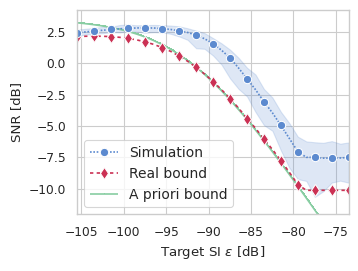

In [31]:
fig, ax2 = plt.subplots(1,1)
colors = sns.color_palette("muted")
pt_plot = max(powers)
plot_title = f"SQNR vs. Self-interference (Bandwidth: {sig_bw_hz*1e-6:.1f} MHz @ {fc*1e-9} GHz)"
title_pt = f"Tx Power: {pt_plot} dBm"

xlims = empiric_df["si_db"].min(), empiric_df["si_db"].max()
ylims = (-12, plot_df.sqnr_db.max() + 1)

ln_order = style_order=[bnd_label, ach_label, sim_label]

sns.lineplot(plot_df.query(f"pt_dbm=={pt_plot}"), x="si_gain", y="sqnr_db", style=" ", style_order=ln_order,
             hue_order=ln_order,
             markers=[",", "d", "o"], dashes=((1,0), (2,2), (1,1)),
             errorbar=lambda x: (min(x), max(x)),
             hue=" ", markevery=2, markersize=6, palette=[viz.palette[1], viz.palette[3], viz.palette[0]],
             ax=ax2)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[::-1], labels[::-1], fontsize="10")

plt.sca(ax2)
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel(r"Target SI $\varepsilon$ [dB]")
plt.ylabel("SNR [dB]")

wf_plot = waveforms[0]
title_wf = wf_plot

plt.savefig(plot_path/"bound_sqnr.pdf", bbox_inches="tight")